**Name: Trilokinath Modi**

# Basic Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

import torch
import csv
import pandas
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

import time

from collections import defaultdict, Counter

import matplotlib.pyplot as plt
import numpy as np
from spacy.lang.en import English

%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

nlp = English()

In [3]:
filePath = "/content/drive/My Drive/MLNLP/FinalAssignment/train_reg.csv"
filePathTest = "/content/drive/My Drive/MLNLP/FinalAssignment/test_reg.csv"
filePathResult = "/content/drive/My Drive/MLNLP/FinalAssignment/"

In [5]:
def readData(fileName):
    # colnames = ['id', 'text', 'is_humor', 'humor_rating', 'humor_controversy', 'offense_rating']
    train_data = pandas.read_csv(fileName)
    X = train_data.text.tolist()
    Y = train_data.humor_rating.tolist()
    return X, Y

def readDataTest(fileName):
    test_data = pandas.read_csv(fileName)
    xTest = test_data.text.tolist()
    return xTest  
  
def writeData(fileName, testData, resultList):
  fileHandler = open(fileName, 'w')
  with fileHandler:
    headings = ['text', 'humor_rating']
    writer = csv.writer(fileHandler)
    writer.writerows(zip(testData, resultList))
    # for iResult in resultList:
    #   fileHandler.write("%s\n" % iResult)

def evaluateTest(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    f1score = tp / (tp + 0.5*(fp + fn))
    return accuracy, f1score

# Setup classes used by all methods

The vocabulary class is modified to add 2 special cases used in continuous bag of words approach. The special cases are discussed under the CBOW title. Specifically, the build method is modified.

In [6]:
PAD = '___PAD___'
UNKNOWN = '___UNKNOWN___'

class Vocabulary:
    """Manages the numerical encoding of the vocabulary."""
    
    def __init__(self, tokenizer=None, max_voc_size=None):

        # String-to-integer mapping
        self.stoi = None

        # Integer-to-string mapping
        self.itos = None

        # Tokenizer that will be used to split document strings into words.
        if tokenizer:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = lambda s: s.split()

        # Maximally allowed vocabulary size.
        self.max_voc_size = max_voc_size
        
    def build(self, docs, position = None, ngrams = None, flagNoStop = None):
        """Builds the vocabulary, based on a set of documents."""
        
        if ngrams == None:
          # Sort all words by frequency
          word_freqs = Counter(w for doc in docs for w in self.tokenizer(doc))
          word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)
        
        elif flagNoStop == None:
          # Sort all words by frequency
          positionIndex = 0
          word_freqs = Counter()
          for doc in docs:
            currentDoc = self.tokenizer(doc)
            if int(position[positionIndex]) + ngrams < len(currentDoc) and int(position[positionIndex]) - ngrams >= 0:
              for words in range(int(position[positionIndex]) - ngrams, int(position[positionIndex]) + ngrams + 1):        
                word_freqs.update([currentDoc[words]])
            elif int(position[positionIndex]) + ngrams < len(currentDoc):
              for words in range(int(position[positionIndex]), int(position[positionIndex]) + ngrams + 1):
                word_freqs.update([currentDoc[words]])
            elif int(position[positionIndex]) - ngrams >= 0:
              for words in range(int(position[positionIndex]) - ngrams, int(position[positionIndex]) + 1):
                word_freqs.update([currentDoc[words]])
            positionIndex += 1
          word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)

        elif flagNoStop == 1:
          # Sort all words by frequency
          positionIndex = 0
          word_freqs = Counter()
          for doc in docs:
            currentDoc = self.tokenizer(doc)
            currentDocNoStop = []
            for iToken in range(len(currentDoc)):
              if not nlp.vocab[currentDoc[iToken]].is_stop and iToken not in ['.', ',', "?"] and not currentDoc[iToken].isdigit() and iToken != int(position[positionIndex]):
                currentDocNoStop.append(currentDoc[iToken])
              if iToken == int(position[positionIndex]):
                currentDocNoStop.append(currentDoc[iToken])
                newPosition = len(currentDocNoStop) - 1
            if newPosition + ngrams < len(currentDocNoStop) and newPosition - ngrams >= 0:
              for words in range(newPosition - ngrams, newPosition + ngrams + 1):
                word_freqs.update([currentDocNoStop[words]])
            elif newPosition + ngrams < len(currentDocNoStop):
              for words in range(newPosition, newPosition + ngrams + 1):
                word_freqs.update([currentDocNoStop[words]])
            elif newPosition - ngrams >= 0:
              for words in range(newPosition - ngrams, newPosition + 1):
                word_freqs.update([currentDocNoStop[words]])
            positionIndex += 1
          word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)

        # Build the integer-to-string mapping. The vocabulary starts with the two dummy symbols,
        # and then all words, sorted by frequency. Optionally, limit the vocabulary size.
        if self.max_voc_size:
            self.itos = [PAD, UNKNOWN] + [ w for _, w in word_freqs[:self.max_voc_size-2] ]
        else:
            self.itos = [PAD, UNKNOWN] + [ w for _, w in word_freqs ]

        # Build the string-to-integer map by just inverting the aforementioned map.
        self.stoi = { w: i for i, w in enumerate(self.itos) }
        
    def encode(self, docs):
        """Encodes a set of documents."""
        unkn_index = self.stoi[UNKNOWN]
        return [[self.stoi.get(w, unkn_index) for w in self.tokenizer(doc)] for doc in docs]

    def get_unknown_idx(self):
        """Returns the integer index of the special dummy word representing unknown words."""
        return self.stoi[UNKNOWN]
    
    def get_pad_idx(self):
        """Returns the integer index of the special padding dummy word."""
        return self.stoi[PAD]
    
    def __len__(self):
        return len(self.itos)

Class used to store document identities and create batches

In [7]:
class DocumentDataset(Dataset):
    """A Dataset that stores a list of documents and their corresponding category labels."""
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
    def __len__(self):
        return len(self.X)

class DocumentBatcher:
    """A collator that builds a batch from a number of documents."""
    
    def __init__(self, voc):
        # Find the integer index of the dummy padding word.
        self.pad = voc.get_pad_idx()
    
    def __call__(self, XY):
        """Build a batch from a number of documents. Returns two tensors X and Y, where
        X is the document tensor, of shape [n_docs, max_doc_length]

        and 
        
        Y is the label tensor, of shape [n_docs].
        """
        
        # How long is the longest document in this batch?
        max_len = max(len(x) for x, _ in XY)

        # Build the document tensor. We pad the shorter documents so that all documents
        # have the same length.
        Xpadded = torch.as_tensor([x + [self.pad]*(max_len-len(x)) for x, _ in XY])

        # Build the label tensor.
        Y = torch.as_tensor([y for _, y in XY])

        return Xpadded, Y

Text classifier class which performs the preprocessing, training and prediction for each model. This class is inshort the heart of the program. The class is modified to accomodate changes made in Vocabulary class. Specifically, the preprocess method is modified and simple early stopping criteria is included i.e. the model stops training if for any 3 epochs in previous 5 epochs the validation loss has increased. This early stopping criteria is used for all models.

In [50]:
class TextClassifier:
    """A text classifier based on a neural network."""
    
    def __init__(self, params):
        self.params = params
        self.flagEpoch = 0
        
    def epoch(self, batches, optimizer=None):
        n_instances = 0
        total_loss = 0
        
        for Xbatch, Ybatch in batches:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            predictions = self.model(Xbatch)
            loss = self.loss(torch.transpose(predictions,0,1)[0], Ybatch)

            total_loss += loss.item()
            n_instances += Ybatch.shape[0]

            if optimizer:
                optimizer.zero_grad()                
                loss.backward()
                optimizer.step()
           
        return total_loss
    
    def preprocess(self, X, Y, position = None, ngrams = None, flagNoStop = None):
        """Carry out the document preprocessing, then build `DataLoader`s for the training and validation sets."""

        if ngrams == None:
          Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=0)
          self.voc = Vocabulary(max_voc_size=self.params.max_voc_size)
          self.voc.build(Xtrain)

        self.voc_size = len(self.voc)
        
        batcher = DocumentBatcher(self.voc)
        
        train_dataset = DocumentDataset(self.voc.encode(Xtrain), Ytrain)
        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True,
                                  collate_fn=batcher)
        val_dataset = DocumentDataset(self.voc.encode(Xval), Yval)
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=True,
                                collate_fn=batcher)
    
    def set_model(self, model):
        """Provide a neural network model for this document classifier."""
        self.model = model
    
    def train(self):
        """Train the model. We assume that a dataset and a model have already been provided."""
        par = self.params
        
        # If we're using a GPU, put the model there.
        self.model.to(par.device)
    
        # Declare a loss function, in this case the cross-entropy.
        self.loss = torch.nn.MSELoss()

        # An optimizer for updating the neural network. We use the Adam optimizer.
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.eta, weight_decay=par.decay)

        # We'll log the loss and accuracy scores encountered during training.
        self.history = defaultdict(list)
        epoch = 0
        while epoch < par.n_epochs+1 and self.flagEpoch == 0:
            epoch += 1
            
            t0 = time.time()
            
            # Set the model in training mode, enabling dropout modules.
            self.model.train()
            
            # Run the model on the training data.
            train_loss = self.epoch(self.train_loader, optimizer)
            
            # Set the model in evaluation mode, disabling dropout modules.
            self.model.eval()

            # Run the model on the validation data.            
            val_loss = self.epoch(self.val_loader)
            
            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['time'].append(t1-t0)
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch}: train loss: {train_loss:.4f}, '
                      + f'val loss: {val_loss:.4f}, time: {t1-t0:.4f}')

            flagEpochArray = np.zeros(5, dtype = int)
            if epoch > 6:
              for iEpoch in range(1,6):
                if self.history['val_loss'][epoch - iEpoch] - self.history['val_loss'][epoch - (iEpoch + 1)] > 0:
                  flagEpochArray[iEpoch - 1] = 1
            if np.sum(flagEpochArray) >= 4:
              self.flagEpoch = 1
        
    def predict(self, X):
        """Run a trained document classifier on a set of documents and return the predictions."""
        batcher = DocumentBatcher(self.voc)
        
        # Build a DataLoader to generate the batches, as above.
        dummy_labels = [np.random.randint(0,5,1) for x in X]       
        dataset = DocumentDataset(self.voc.encode(X), dummy_labels)
        loader = DataLoader(dataset, self.params.batch_size, collate_fn=batcher)

        # Apply the model to all the batches and aggregate the predictions.
        self.model.eval()
        output = []
        for Xbatch, Ybatch in loader:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            predictions = self.model(Xbatch)
            predictions = torch.transpose(predictions,0,1)[0]
            output.extend(predictions.detach().cpu().numpy())
        return output

# Training Model CBOW

Class that provides the embedded input tensor.

In [9]:
class CBoWRepresentation(nn.Module):
    
    def __init__(self, voc_size, emb_dim):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, emb_dim)

    def forward(self, X):        
        embedded = self.embedding(X)        
        return embedded.mean(dim=1)
    
        # final shape: (n_docs, emb_dim)

Class to define the hyperparameters for CBOW model and performs the operations done by main i.e. calling the right functions from Text Classifier class to perform the training.

In [13]:
class TextClassifierParameters:
    device = 'cuda'
    
    max_voc_size = None
    
    n_epochs = 50
    batch_size = 64
    
    eta = 3e-3
    decay = 0 #1e-6
    dropout = 0 #0.2
    
    emb_dim = 32

def main_cbow(caseNumber):    
    #torch.manual_seed(0)

    X, Y = readData(filePath)
    
    params = TextClassifierParameters()
    
    clf = TextClassifier(params)
    
    if caseNumber == 1:
      clf.preprocess(X, Y, ngrams = None, flagNoStop = None)
    
    # Create a classification model: a continuous bag-of-words representation with a linear classifier 
    # on top, and dropout to reduce overfitting.
    clf.set_model(nn.Sequential(
            CBoWRepresentation(clf.voc_size, params.emb_dim),
            nn.Dropout(params.dropout),
            # nn.Linear(in_features=params.emb_dim, out_features=10),
            nn.Linear(in_features=params.emb_dim, out_features=1)

    ))

    clf.train()
  
    return clf

In [15]:
maxIter = 5
cbow_classifier = list()
for icase in range(1):
  cbow_classifier.append(list())
  for iterations in range(maxIter):
    cbow_classifier[icase].append(main_cbow(icase + 1))

Epoch 5: train loss: 18.4179, val loss: 4.2519, time: 0.1587
Epoch 10: train loss: 13.1749, val loss: 3.5725, time: 0.1534
Epoch 15: train loss: 10.7444, val loss: 3.5379, time: 0.1542
Epoch 20: train loss: 8.4006, val loss: 3.7470, time: 0.1587
Epoch 25: train loss: 6.1082, val loss: 3.9170, time: 0.1538
Epoch 5: train loss: 18.1926, val loss: 4.2516, time: 0.1702
Epoch 10: train loss: 12.7500, val loss: 3.8400, time: 0.1544
Epoch 5: train loss: 19.4223, val loss: 4.5288, time: 0.1510
Epoch 10: train loss: 13.0815, val loss: 3.6382, time: 0.1514
Epoch 15: train loss: 10.6499, val loss: 3.6723, time: 0.1585
Epoch 20: train loss: 8.3453, val loss: 3.6649, time: 0.1561
Epoch 5: train loss: 16.6354, val loss: 4.0757, time: 0.1562
Epoch 10: train loss: 12.3920, val loss: 3.8133, time: 0.1621
Epoch 15: train loss: 9.7328, val loss: 3.7219, time: 0.1585
Epoch 20: train loss: 7.0746, val loss: 3.8292, time: 0.1614
Epoch 5: train loss: 16.3973, val loss: 3.9392, time: 0.1615
Epoch 10: train lo

In [28]:
# Plot losses and accuracies for the training and validation sets.
def plotit():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in range(1):
    for iterationNumber in range(maxIter):
      # plt.plot(cbow_classifier[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
      lbl = "iteration_" + str(iterationNumber + 1)
      plt.plot(cbow_classifier[icase][iterationNumber].history['val_loss'], label = lbl)   
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("CBOW Validation Loss-Epoch Plot for 5 iterations")
    plt.legend()
    figName = "/content/drive/My Drive/MLNLP/FinalAssignment/CBOW_reg.eps"
    plt.savefig(figName)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


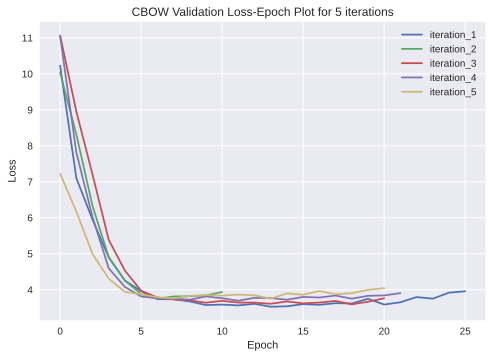

In [29]:
plotit()

**Performance on test dataset**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


Mean Squared Error : 0.3070647279838681
R^2 : 0.05778144618849146
Accuracy wothin 0.5 and -0.5 is  0.6444805194805194


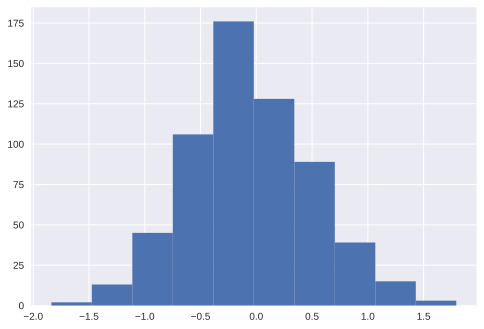

In [33]:
randomModel = np.asscalar(np.random.randint(0, maxIter, 1))
X, Y = readData(filePathTest)
icase = 0
resultList = cbow_classifier[icase][randomModel].predict(X)
fileNameRes = "CBOW_reg_.csv"
fileName = filePathResult + fileNameRes
writeData(fileName, X, resultList)

mse = mean_squared_error(Y, resultList)
r_square = r2_score(Y, resultList)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

countMe = 0
for i in range(len(resultList)):
  if -0.5 <= resultList[i] - Y[i] <= 0.5:
    countMe += 1
accMe = countMe/len(Y)
print("Accuracy wothin 0.5 and -0.5 is ", accMe)

difference = [resultList[i] - Y[i] for i in range(len(Y))]
plt.figure(icase)
plt.hist(difference)
histName = "/content/drive/My Drive/MLNLP/FinalAssignment/hist_CBOW.eps"
plt.savefig(histName)


In [39]:
writeData(fileName, Y, resultList)

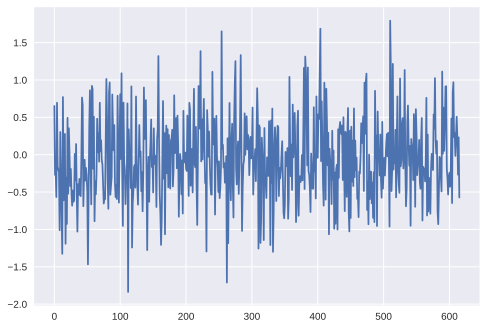

In [38]:
plt.figure()
plt.plot([resultList[i] - Y[i] for i in range(len(Y))])
figName = "/content/drive/My Drive/MLNLP/FinalAssignment/CBOW_residual.eps"
plt.savefig(figName)

# RNN

Class that provides the embedded input tensor i.e. final states of input and output layer.

In [51]:
class TextClassifier:
    """A text classifier based on a neural network."""
    
    def __init__(self, params):
        self.params = params
        self.flagEpoch = 0
        
    def epoch(self, batches, optimizer=None):
        n_instances = 0
        total_loss = 0
        
        for Xbatch, Ybatch in batches:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            predictions = self.model(Xbatch)
            loss = self.loss(torch.transpose(predictions,0,1)[0], Ybatch)

            total_loss += loss.item()
            n_instances += Ybatch.shape[0]

            if optimizer:
                optimizer.zero_grad()                
                loss.backward()
                optimizer.step()
           
        return total_loss
    
    def preprocess(self, X, Y, position = None, ngrams = None, flagNoStop = None):
        """Carry out the document preprocessing, then build `DataLoader`s for the training and validation sets."""

        if ngrams == None:
          Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=0)
          self.voc = Vocabulary(max_voc_size=self.params.max_voc_size)
          self.voc.build(Xtrain)

        self.voc_size = len(self.voc)
        
        batcher = DocumentBatcher(self.voc)
        
        train_dataset = DocumentDataset(self.voc.encode(Xtrain), Ytrain)
        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True,
                                  collate_fn=batcher)
        val_dataset = DocumentDataset(self.voc.encode(Xval), Yval)
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=True,
                                collate_fn=batcher)
    
    def set_model(self, model):
        """Provide a neural network model for this document classifier."""
        self.model = model
    
    def train(self):
        """Train the model. We assume that a dataset and a model have already been provided."""
        par = self.params
        
        # If we're using a GPU, put the model there.
        self.model.to(par.device)
    
        # Declare a loss function, in this case the cross-entropy.
        self.loss = torch.nn.MSELoss()

        # An optimizer for updating the neural network. We use the Adam optimizer.
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.eta, weight_decay=par.decay)

        # We'll log the loss and accuracy scores encountered during training.
        self.history = defaultdict(list)
        epoch = 0
        while epoch < par.n_epochs+1 and self.flagEpoch == 0:
            epoch += 1
            
            t0 = time.time()
            
            # Set the model in training mode, enabling dropout modules.
            self.model.train()
            
            # Run the model on the training data.
            train_loss = self.epoch(self.train_loader, optimizer)
            
            # Set the model in evaluation mode, disabling dropout modules.
            self.model.eval()

            # Run the model on the validation data.            
            val_loss = self.epoch(self.val_loader)
            
            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['time'].append(t1-t0)
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch}: train loss: {train_loss:.4f}, '
                      + f'val loss: {val_loss:.4f}, time: {t1-t0:.4f}')

            flagEpochArray = np.zeros(5, dtype = int)
            if epoch > 3:
              for iEpoch in range(1,3):
                if self.history['val_loss'][epoch - iEpoch] - self.history['val_loss'][epoch - (iEpoch + 1)] > 0:
                  flagEpochArray[iEpoch - 1] = 1
            if np.sum(flagEpochArray) >= 2:
              self.flagEpoch = 1
        
    def predict(self, X):
        """Run a trained document classifier on a set of documents and return the predictions."""
        batcher = DocumentBatcher(self.voc)
        
        # Build a DataLoader to generate the batches, as above.
        dummy_labels = [np.random.randint(0,5,1) for x in X]       
        dataset = DocumentDataset(self.voc.encode(X), dummy_labels)
        loader = DataLoader(dataset, self.params.batch_size, collate_fn=batcher)

        # Apply the model to all the batches and aggregate the predictions.
        self.model.eval()
        output = []
        for Xbatch, Ybatch in loader:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            predictions = self.model(Xbatch)
            predictions = torch.transpose(predictions,0,1)[0]
            output.extend(predictions.detach().cpu().numpy())
        return output

In [52]:
class RNNRepresentation(nn.Module):

    def __init__(self, voc_size, emb_dim, rnn_size, icase):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, emb_dim)
        self.icase = icase

        # The RNN module: either a basic RNN, LSTM, or a GRU.
        if icase == 1:
          self.rnn = nn.RNN(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif icase == 2:
          self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif icase == 3:
          self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)

    def forward(self, X):
        # X is a document tensor with shape (n_docs, n_words)

        embedded = self.embedding(X)

        # Shape of embedded: (n_docs, n_words, emb_dim)

        # The RNNs return two tensors: one representing the outputs at all positions
        # of the final layer, and another representing the final states of each layer.
        # In this example, we'll use just the final states.
        # NB: for a bidirectional RNN, the final state corresponds to the *last* token
        # in the forward direction and the *first* token in the backward direction.
        if self.icase == 1 or self.icase == 3:
          rnn_out, final_state = self.rnn(embedded)
        elif self.icase == 2:
          # use the following instead if you're using an LSTM:
          rnn_out, (final_state, _) = self.rnn(embedded)

        # For a GRU or simple RNN, final_state is a single tensor
        # of the shape (n_layers, n_docs, 2*rnn_size)

        top_forward = final_state[-2]
        top_backward = final_state[-1]
        top_both = torch.cat([top_forward, top_backward], dim=1)

        return top_both

In [53]:
class TextClassifierParameters():
    """Container class to store the hyperparameters that control the training process."""

    # Computation device: 'cuda' or 'cpu'
    device = 'cuda'

    # Maximal vocabulary size: by increasing, the system will probably be slower but more accurate.
    max_voc_size = 1000

    # Number of training epochs.
    n_epochs = 50

    # Size of batches: how many documents to process in parallel.
    batch_size = 64

    # Learning rate in the Adam optimizer.
    eta = 2e-3

    # Weight decay (L2 regularization) in the Adam optimizer.
    decay = 1e-5

    # Dropout probability.
    dropout = 0.2

    # Word embedding dimensionality.
    emb_dim = 64

    # RNN size
    rnn_size = 128  # 128


def main_rnn(icase, jcase):

    # Read the data.
    X, Y = readData(filePath)

    print(f'Loaded {len(Y)} documents.')

    # Initialize the text classifier
    params = TextClassifierParameters()
    clf = TextClassifier(params)
    if jcase == 1:
      clf.params.emb_dim = 32
    elif jcase == 2:
      clf.params.emb_dim = 64
    elif jcase == 3:
      clf.params.emb_dim = 128

    # Preprocess the data.
    clf.preprocess(X, Y, ngrams = None, flagNoStop = None)

    # Create a classification model: a bag-of-words representation with a linear classifier on top,
    # and dropout to reduce overfitting.

    clf.set_model(nn.Sequential(
        RNNRepresentation(voc_size=clf.voc_size, emb_dim=params.emb_dim,
                          rnn_size=params.rnn_size, icase = icase),
        nn.Dropout(params.dropout),
        nn.Linear(in_features=2 * params.rnn_size, out_features = 1),
        # nn.Linear(10, 1)

    ))

    # Train the classifier.
    clf.train()

    return clf


In [54]:
maxIter = 5
rnn_classifier = list()
for icase in range(2):
  rnn_classifier.append(list())
  for iterations in range(maxIter):
    rnn_classifier[icase].append(main_rnn(icase + 2, 2))

Loaded 4316 documents.
Epoch 5: train loss: 15.6665, val loss: 3.9616, time: 0.9200
Loaded 4316 documents.
Epoch 5: train loss: 15.7401, val loss: 4.1367, time: 0.9371
Loaded 4316 documents.
Epoch 5: train loss: 15.0179, val loss: 3.9923, time: 0.9305
Loaded 4316 documents.
Epoch 5: train loss: 16.0924, val loss: 3.9885, time: 0.9304
Loaded 4316 documents.
Epoch 5: train loss: 15.0340, val loss: 4.1738, time: 0.9111
Loaded 4316 documents.
Epoch 5: train loss: 14.8006, val loss: 3.9570, time: 0.8857
Loaded 4316 documents.
Epoch 5: train loss: 15.3231, val loss: 4.1667, time: 0.8856
Loaded 4316 documents.
Epoch 5: train loss: 15.0142, val loss: 4.1501, time: 0.8977
Loaded 4316 documents.
Epoch 5: train loss: 14.9660, val loss: 4.0540, time: 0.8963
Loaded 4316 documents.
Epoch 5: train loss: 15.4494, val loss: 4.2355, time: 0.9009
Epoch 10: train loss: 8.8234, val loss: 5.1168, time: 0.8846


In [55]:
# Plot losses and accuracies for the training and validation sets.
def plotit():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in range(2):
    plt.figure()
    for iterationNumber in range(maxIter):
      # plt.plot(cbow_classifier[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
      lbl = "iteration_" + str(iterationNumber + 1)
      plt.plot(rnn_classifier[icase][iterationNumber].history['val_loss'], label = lbl)   
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if icase == 0:
      plt.title("LSTM Validation Loss-Epoch Plot for 5 iterations")
      figName = "/content/drive/My Drive/MLNLP/FinalAssignment/LSTM_reg.eps"
    else:
      plt.title("GRU Validation Loss-Epoch Plot for 5 iterations")
      figName = "/content/drive/My Drive/MLNLP/FinalAssignment/GRU_reg.eps"
    plt.legend()
    plt.savefig(figName)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


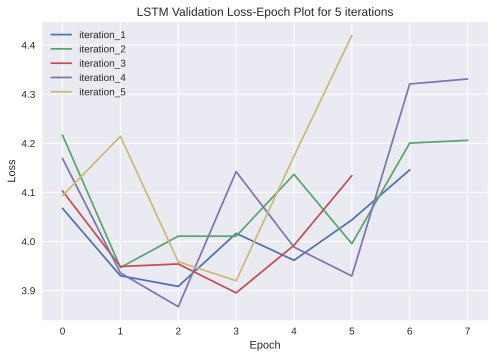

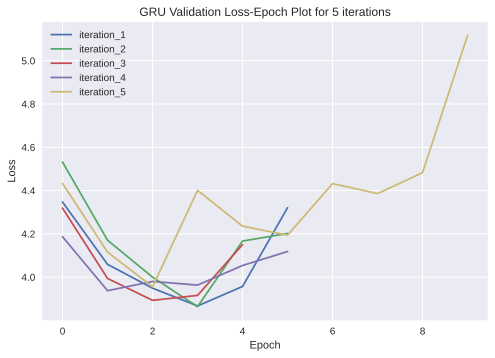

In [56]:
plotit()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Mean Squared Error : 0.32699041376676863
R^2 : -0.0033599000199644458
Accuracy wothin 0.5 and -0.5 is  0.6103896103896104


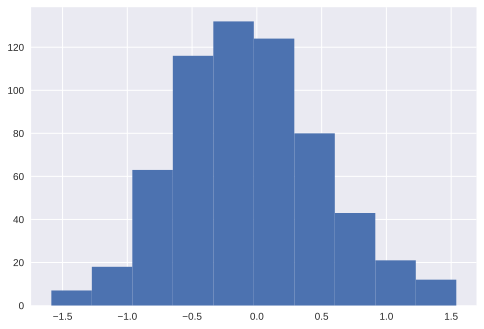

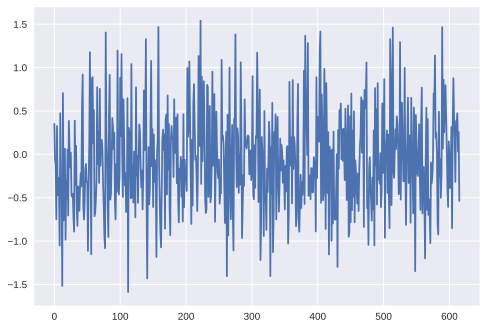

In [60]:
# LSTM performances icase = 0
randomModel = np.asscalar(np.random.randint(0, maxIter, 1))
X, Y = readData(filePathTest)
icase = 0
resultList = rnn_classifier[icase][randomModel].predict(X)
fileNameRes = "LSTM_reg_.csv"
fileName = filePathResult + fileNameRes
writeData(fileName, X, resultList)

mse = mean_squared_error(Y, resultList)
r_square = r2_score(Y, resultList)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

countMe = 0
for i in range(len(resultList)):
  if -0.5 <= resultList[i] - Y[i] <= 0.5:
    countMe += 1
accMe = countMe/len(Y)
print("Accuracy wothin 0.5 and -0.5 is ", accMe)

difference = [resultList[i] - Y[i] for i in range(len(Y))]
plt.figure(icase)
plt.hist(difference)
histName = "/content/drive/My Drive/MLNLP/FinalAssignment/hist_LSTM.eps"
plt.savefig(histName)

plt.figure()
plt.plot([resultList[i] - Y[i] for i in range(len(Y))])
figName = "/content/drive/My Drive/MLNLP/FinalAssignment/LSTM_residual.eps"
plt.savefig(figName)

writeData(fileName, Y, resultList)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Mean Squared Error : 0.3482664954973168
R^2 : -0.0686448941336022
Accuracy wothin 0.5 and -0.5 is  0.6266233766233766


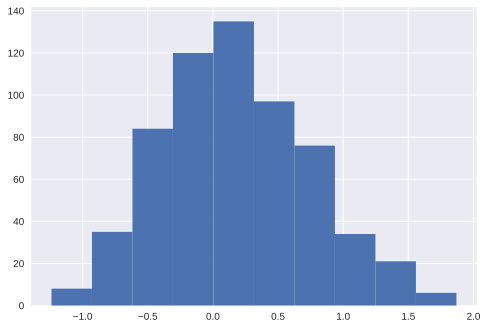

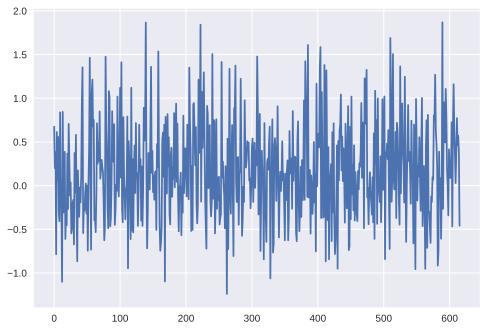

In [63]:
# GRU performances icase = 1
randomModel = np.asscalar(np.random.randint(0, maxIter, 1))
X, Y = readData(filePathTest)
icase = 1
resultList = rnn_classifier[icase][randomModel].predict(X)
fileNameRes = "GRU_reg_.csv"
fileName = filePathResult + fileNameRes
writeData(fileName, X, resultList)

mse = mean_squared_error(Y, resultList)
r_square = r2_score(Y, resultList)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

countMe = 0
for i in range(len(resultList)):
  if -0.5 <= resultList[i] - Y[i] <= 0.5:
    countMe += 1
accMe = countMe/len(Y)
print("Accuracy wothin 0.5 and -0.5 is ", accMe)

difference = [resultList[i] - Y[i] for i in range(len(Y))]
plt.figure(icase)
plt.hist(difference)
histName = "/content/drive/My Drive/MLNLP/FinalAssignment/hist_GRU.eps"
plt.savefig(histName)

plt.figure()
plt.plot([resultList[i] - Y[i] for i in range(len(Y))])
figName = "/content/drive/My Drive/MLNLP/FinalAssignment/GRU_residual.eps"
plt.savefig(figName)

writeData(fileName, Y, resultList)